# Module 1.10: Plotting Your Data (with TSForge)

> **Goal:** See patterns quickly with minimal code; know which plots answer which questions.

**Key Quotes:**
- "Different plots answer different questions."
- "EDA is about insight, not decoration."

**Deliverable:** Visual Diagnostics Notebook

---

## Prerequisites

**Input from Module 1.9:**
- `./output/m5_weekly_clean.parquet` — Clean weekly data with columns: `unique_id`, `ds`, `y`, `is_imputed`

**What this module produces:**
- `./output/series_zero_stats.parquet` — Zero percentage by series (used in Module 1.11)
- Visual diagnostics and pattern observations

**Data Flow:**
```
Module 1.8 (daily clean) 
    → Module 1.9 (weekly aggregation, gap fill, outliers)
        → Module 1.10 (plotting, EDA) ← YOU ARE HERE
            → Module 1.11 (pattern interpretation, segmentation)
```

---

## 1. Introduction

**Why plot first?**

The first rule of time series is: **plot the data**. Summary statistics can hide critical patterns that are immediately obvious in a graph.

In this module, we'll use TSForge's plotting utilities to:
- Visualize trends, seasonality, and anomalies
- Compare series across categories
- Assess autocorrelation and intermittency
- Decompose series into trend + seasonal + residual

**Core Principle:** Each plot type answers a specific question about your data.

## 2. Setup & Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tsforge as tsf
# TSForge plotting utilities
from tsforge.plots import (
    plot_timeseries,
    plot_autocorrelation,
    plot_seasonal
)
# Note: plot_decomposition is defined locally below (not in tsforge.plots)

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('✓ Setup complete')

/Users/lindsaytruong/anaconda3/envs/ts_forge/lib/python3.10/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/lindsaytruong/anaconda3/envs/ts_forge/lib/python3.10/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


✓ Setup complete


In [2]:
# Load cleaned weekly data from Module 1.9
df = pd.read_parquet('./output/m5_weekly_clean.parquet')

print(f"Loaded {len(df):,} rows")
print(f"Series: {df['unique_id'].nunique():,}")
print(f"Date range: {df['ds'].min().date()} to {df['ds'].max().date()}")
print(f"Columns: {df.columns.tolist()}")

# Note: Module 1.9 outputs: unique_id, ds, y, is_imputed
# M5 format: {CAT}_{DEPT_NUM}_{ITEM_NUM}_{STATE}_{STORE_NUM}
# Example: HOBBIES_1_001_CA_1

# Extract metadata from unique_id
df['store_id'] = df['unique_id'].str.extract(r'_([A-Z]{2}_\d+)$')[0]  # CA_1, TX_3, etc.
df['state_id'] = df['store_id'].str[:2]  # CA, TX, WI
df['item_id'] = df['unique_id'].str.replace(r'_[A-Z]{2}_\d+$', '', regex=True)  # HOBBIES_1_001
df['dept_id'] = df['unique_id'].str.extract(r'^([A-Z]+_\d+)')[0]  # HOBBIES_1, FOODS_3
df['cat_id'] = df['unique_id'].str.extract(r'^([A-Z]+)')[0]  # HOBBIES, FOODS, HOUSEHOLD

print(f"\nExtracted metadata:")
print(f"  Categories: {df['cat_id'].nunique()} - {df['cat_id'].unique().tolist()}")
print(f"  Departments: {df['dept_id'].nunique()}")
print(f"  Stores: {df['store_id'].nunique()}")

df.head()

Loaded 6,848,887 rows
Series: 30,490
Date range: 2011-01-29 to 2016-06-25
Columns: ['unique_id', 'ds', 'y', 'is_imputed']

Extracted metadata:
  Categories: 3 - ['FOODS', 'HOBBIES', 'HOUSEHOLD']
  Departments: 7
  Stores: 10


,unique_id,ds,y,is_imputed,store_id,state_id,item_id,dept_id,cat_id
0,FOODS_1_001_CA_1,2011-01-29,3.0,0,CA_1,CA,FOODS_1_001,FOODS_1,FOODS
1,FOODS_1_001_CA_1,2011-02-05,9.0,0,CA_1,CA,FOODS_1_001,FOODS_1,FOODS
2,FOODS_1_001_CA_1,2011-02-12,7.0,0,CA_1,CA,FOODS_1_001,FOODS_1,FOODS
3,FOODS_1_001_CA_1,2011-02-19,8.0,0,CA_1,CA,FOODS_1_001,FOODS_1,FOODS
4,FOODS_1_001_CA_1,2011-02-26,14.0,0,CA_1,CA,FOODS_1_001,FOODS_1,FOODS


## 3. The Plot-Question Framework

Before making a plot, ask: **What question am I trying to answer?**

| I want to know... | Use this plot | Function |
|-------------------|---------------|----------|
| Overall pattern | Line plot | `plot_timeseries()` |
| Is there a trend? | Smoothed line | `plot_timeseries(smooth_window=)` |
| Category differences | Grouped plots | `plot_timeseries(group_col=)` |
| Annual seasonality | Seasonal (week-of-year) | `plot_seasonal(freq='W')` |
| Monthly patterns | Seasonal (month) | `plot_seasonal(freq='M')` |
| Demand persistence | ACF | `plot_autocorrelation()` |
| Signal vs noise | Decomposition | `plot_decomposition()` (defined below) |

**Note:** We're working with weekly data, so we see annual cycles (52 weeks), not daily patterns.

**Golden rule:** "Different plots answer different questions."

## 4. Time Series Plots

### 4.1 Basic Line Plots

The most fundamental view: how does demand change over time?

In [3]:
# Basic time series plot - sample 3 random series
plot_timeseries(
    df=df,
    id_col='unique_id',
    date_col='ds',
    value_col='y',
    ids=3,
    mode='dropdown'
)

### 4.2 With Smoothing

Add a moving average to highlight the underlying trend:

In [4]:
# With smoothing to see trends more clearly
plot_timeseries(
    df=df,
    id_col='unique_id',
    date_col='ds',
    value_col='y',
    ids=3,
    mode='dropdown',
    smooth_window=4  # 4-week moving average
)

### What to Look For

| Pattern | Visual Sign | Implication |
|---------|-------------|-------------|
| **Trend** | Upward/downward slope | May need trend component |
| **Level shift** | Sudden jump or drop | External event, regime change |
| **Regular spikes** | Peaks at same time each year | Seasonal pattern |
| **Increasing volatility** | Variance grows with level | Consider log transform |

## 5. Grouped Time Series

Compare patterns across categories (departments, stores, etc.):

In [5]:
# Compare across departments
plot_timeseries(
    df=df,
    id_col='unique_id',
    date_col='ds',
    value_col='y',
    group_col='dept_id',
    ids=3,
    mode='dropdown',
    smooth_window=4
)

### What to Look For in Grouped Plots

- Do all groups follow the same pattern?
- Are some categories growing while others decline?
- Does seasonality strength differ by category?

**Modeling implication:** Similar patterns → can share model parameters. Different patterns → may need separate models.

## 6. Aggregated Views

Sometimes weekly data is too noisy. Aggregate to monthly for clearer trends:

In [6]:
# Monthly aggregation
plot_timeseries(
    df=df,
    id_col='unique_id',
    date_col='ds',
    value_col='y',
    freq='ME',  # Month-end aggregation
    ids=3,
    mode='dropdown',
    smooth_window=3  # 3-month smoothing
)

**When to aggregate:**
- Weekly too noisy → try monthly
- Want to see long-term trends
- Comparing patterns across years

**Caution:** Aggregation hides within-period patterns (e.g., weekly seasonality disappears in monthly view).

### 7.1 Week-of-Year Patterns (Annual Seasonality)

With weekly data, we can see which weeks of the year have higher/lower demand:

In [7]:
# Week-of-year seasonality (annual pattern across 52 weeks)
# This shows which weeks of the year tend to have higher/lower demand
plot_seasonal(
    df=df,
    id_col='unique_id',
    date_col='ds',
    value_col='y',
    ids=3,
    freq='W',  # Week of year (1-52)
    mode='dropdown',
    kind='line',  # Line to see annual pattern
    engine='plotly'
)

### 7.2 Month-of-Year Patterns

Aggregate weekly data to monthly to see broader seasonal patterns:

In [8]:
# Month-of-year seasonality
plot_seasonal(
    df=df,
    id_col='unique_id',
    date_col='ds',
    value_col='y',
    ids=3,
    freq='M',  # Monthly cycle
    mode='dropdown',
    kind='line',  # Line shows trend
    engine='plotly'
)

### What to Look For in Seasonal Plots

| Pattern | Example | Modeling Implication |
|---------|---------|----------------------|
| Strong annual | December spike, summer dip | Fourier terms (period=52), month features |
| Holiday effects | Thanksgiving, Christmas weeks | Holiday indicator features |
| Consistent pattern | Same shape each year | Standard seasonal methods |
| Changing pattern | Shape varies by year | Time-varying seasonality |

**Note:** With weekly data, we see annual seasonality (52-week cycle), not daily patterns.

## 8. Autocorrelation Plots

Autocorrelation measures how much today's value predicts future values.

### 8.1 ACF Plot

In [9]:
# ACF plot with 52 lags (1 year of weekly data)
# Lag 1 = 1 week ago, Lag 4 ≈ 1 month ago, Lag 52 = 1 year ago
plot_autocorrelation(
    df=df,
    id_col='unique_id',
    date_col='ds',
    value_col='y',
    ids=3,
    lags='[1:52]',  # 52 weeks = 1 year
    freq='W',
    mode='dropdown',
    alpha=0.05  # Significance level
)

/Users/lindsaytruong/anaconda3/envs/ts_forge/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning:

invalid value encountered in divide

/Users/lindsaytruong/anaconda3/envs/ts_forge/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1490: ValueWarning:

Matrix is singular. Using pinv.



### How to Read ACF Plots

The blue shaded area shows the "significance band" - bars outside this band are statistically significant.

| ACF Pattern | What It Means | Model Implication |
|-------------|---------------|-------------------|
| High lag-1, slow decay | Strong persistence | AR terms, trend models |
| Spike at lag 4 | Monthly pattern (4 weeks ≈ 1 month) | Month features |
| Spike at lag 52 | Annual seasonality | Yearly Fourier terms |
| All lags near zero | White noise / random | May be hard to predict |
| Negative lag-1 | Over-correction | Check for over-differencing |

**Note:** With weekly data, lag 1 = 1 week, lag 4 ≈ 1 month, lag 52 = 1 year.

## 9. Distribution & Intermittency

### 9.1 Zero Percentage Analysis

Intermittency (many zeros) requires special handling:

Zero Percentage Distribution:
  Mean: 28.5%
  Median: 19.5%
  Max: 100.0%
  Min: 0.0%


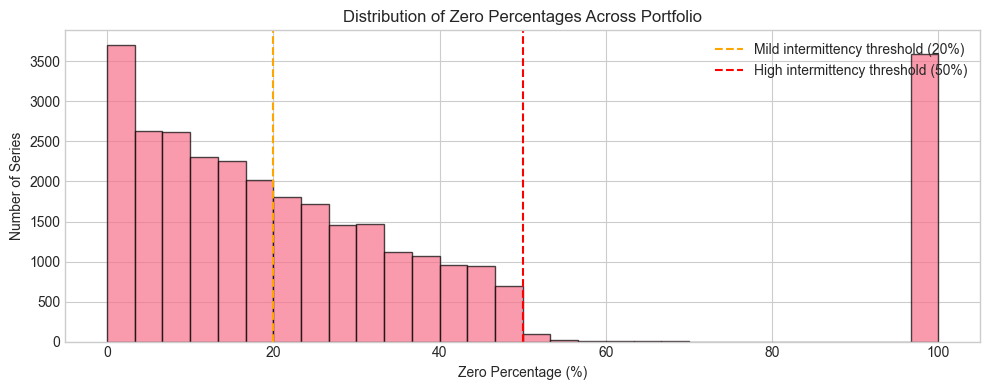

In [ ]:
# Calculate zero percentage by series
zero_stats = df.groupby('unique_id')['y'].apply(lambda x: (x == 0).mean() * 100)

print("Zero Percentage Distribution:")
print(f"  Mean: {zero_stats.mean():.1f}%")
print(f"  Median: {zero_stats.median():.1f}%")
print(f"  Max: {zero_stats.max():.1f}%")
print(f"  Min: {zero_stats.min():.1f}%")

# Distribution of zero percentages
plot_zero_pct(df=df,
    id_col='unique_id',
    date_col='ds',
    value_col='y'
)

### Intermittency Classification

| Zero % | Category | Recommended Approach |
|--------|----------|----------------------|
| 0-10% | Continuous | Standard methods |
| 10-30% | Mildly intermittent | Standard, maybe zero-inflation |
| 30-50% | Intermittent | Croston, SBA, TSB |
| 50-70% | Highly intermittent | Specialized methods |
| 70%+ | Sporadic | Aggregate up, or accept high error |

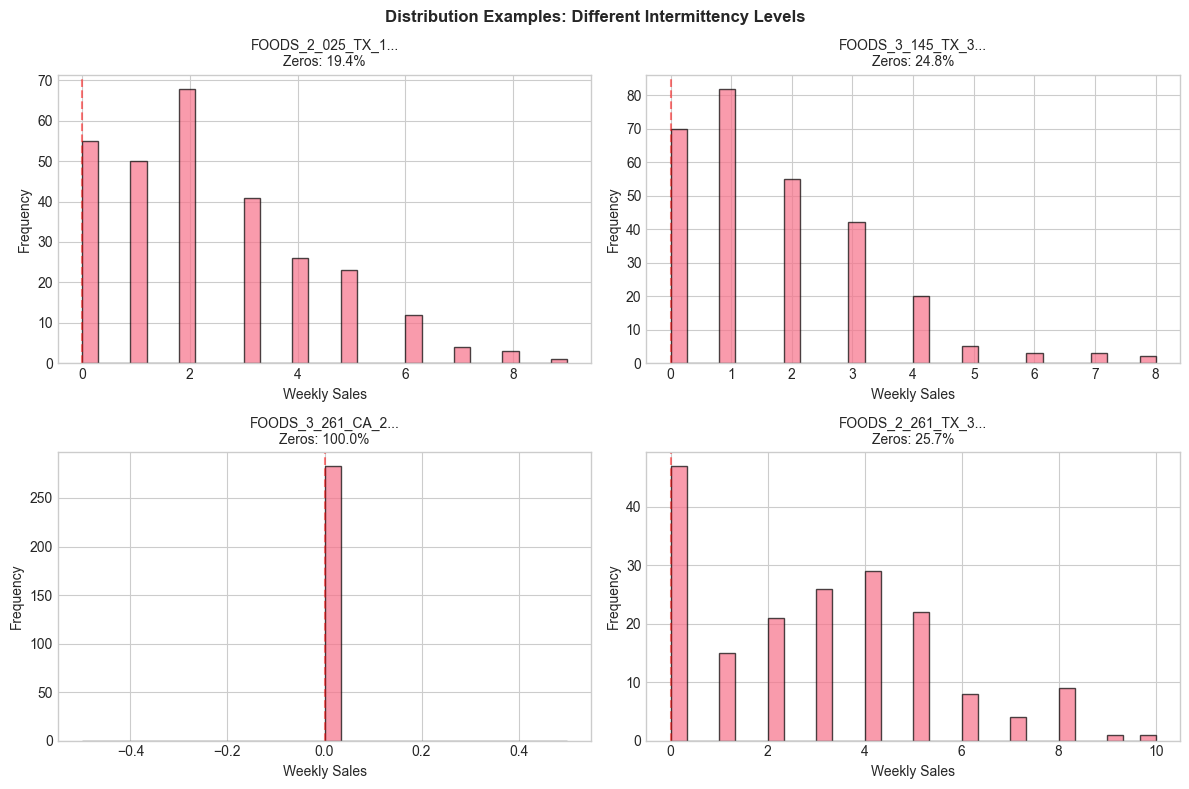

In [ ]:
# Sample series distribution plots
sample_ids = df['unique_id'].drop_duplicates().sample(4, random_state=42).tolist()

plot_intermittency_distribution(sample_ids)

## 10. STL Decomposition

Decompose a series into **Trend + Seasonal + Residual** to understand what's signal vs noise.

In [13]:
from statsmodels.tsa.seasonal import STL

# Select a sample series with enough history
sample_id = df.groupby('unique_id').size().idxmax()  # Series with most observations
sample_data = df[df['unique_id'] == sample_id].sort_values('ds').set_index('ds')['y']

print(f"Decomposing: {sample_id}")
print(f"Observations: {len(sample_data)}")

# STL decomposition (period=52 for annual seasonality in weekly data)
if len(sample_data) >= 104:  # Need at least 2 years
    stl = STL(sample_data, period=52, robust=True)
    result = stl.fit()
    
    # Create decomposition dataframe for plotting
    res_stl = pd.DataFrame({
        'unique_id': sample_id,
        'ds': sample_data.index,
        'observed': result.observed,
        'trend': result.trend,
        'seasonal': result.seasonal,
        'resid': result.resid
    }).reset_index(drop=True)
    
    print("✓ Decomposition complete")
else:
    print(f"⚠ Need at least 104 weeks (2 years) for STL, have {len(sample_data)}")

Decomposing: FOODS_1_001_CA_1
Observations: 283
✓ Decomposition complete


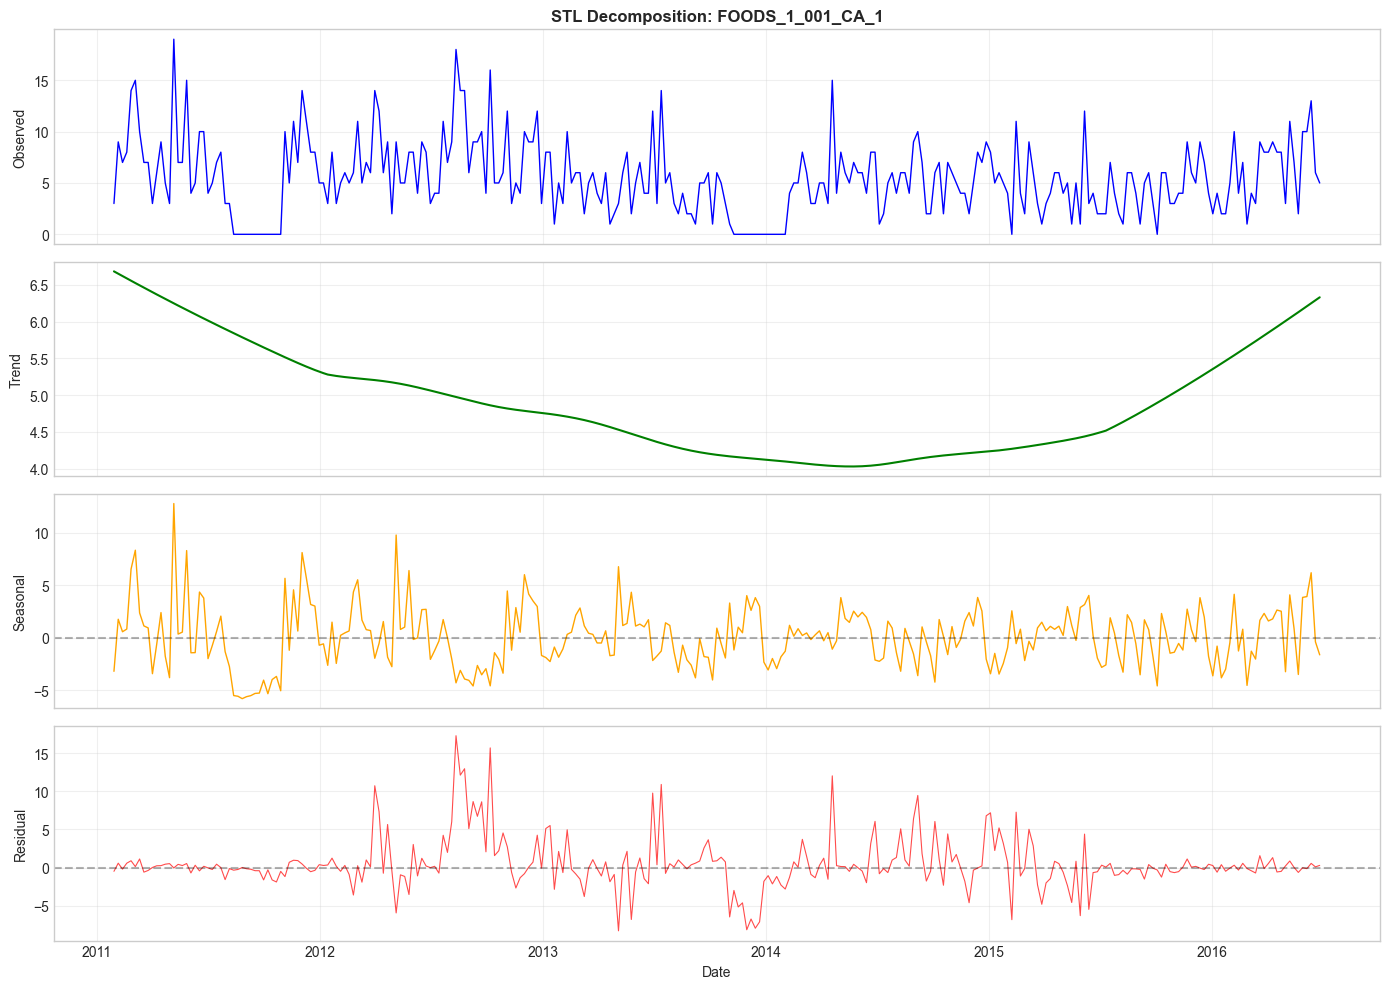


Decomposition Summary:
  Trend range: 4.0 to 6.7
  Seasonal amplitude: 18.6
  Residual std: 3.38


In [ ]:
plot_decomposition(
        df=res_stl,
        id_col='unique_id',
        date_col='ds',
        title=f'STL Decomposition: {sample_id}'
    )
    
# Summary stats
print(f"\nDecomposition Summary:")
print(f"  Trend range: {res_stl['trend'].min():.1f} to {res_stl['trend'].max():.1f}")
print(f"  Seasonal amplitude: {res_stl['seasonal'].max() - res_stl['seasonal'].min():.1f}")
print(f"  Residual std: {res_stl['resid'].std():.2f}")
else:
print("Run the STL decomposition cell above first")

### Interpreting Decomposition

| Component | What It Shows | Good Signs | Bad Signs |
|-----------|---------------|------------|------------|
| **Trend** | Long-term direction | Smooth line | Jagged (picking up noise) |
| **Seasonal** | Repeating patterns | Consistent amplitude | Varying amplitude |
| **Residual** | Unexplained variation | Random scatter | Clear patterns |

## 12. GenAI-Assisted Pattern Interpretation

Use AI to help summarize what you see and generate hypotheses.

### Example Prompt for Claude/GPT:

```
I'm analyzing weekly retail sales for item [ID] at store [STORE].

From my plots, I observe:
- [Describe trend: upward/downward/flat/level shift]
- [Describe seasonality: strong December peaks / no clear pattern]
- [Describe volatility: constant / increasing with level]
- [Describe intermittency: X% zeros]
- [Note any anomalies: irregular spikes, gaps]

Based on these observations:
1. What modeling approaches would you recommend?
2. Should I apply any transformations?
3. What features might capture the patterns I see?
4. Are there any concerns I should investigate further?
```

### Tips for AI-Assisted EDA:
- Be specific about what you observe
- Include quantitative details (e.g., "40% zeros", "2x December spike")
- Ask for reasoning, not just recommendations
- Validate AI suggestions against your domain knowledge

## 13. Key Takeaways

### The Plot-Question Reference

| Question | Plot | Function |
|----------|------|----------|
| Overall pattern | Line | `plot_timeseries()` |
| Trend | Smoothed line | `plot_timeseries(smooth_window=)` |
| Seasonality | Seasonal | `plot_seasonal()` |
| Persistence | ACF | `plot_autocorrelation()` |
| Signal vs noise | Decomposition | `plot_decomposition()` |

### What to Document for Each Series/Segment

1. **Trend:** Direction and strength
2. **Seasonality:** Which cycles are present (weekly, annual)
3. **Intermittency:** Zero percentage classification
4. **Volatility:** Constant or changing with level
5. **Anomalies:** Unexplained spikes or drops

### Golden Rules

- "The first tool in time series is a graph"
- "Different plots answer different questions"
- "EDA is about insight, not decoration"
- Sample diverse series, not just random ones
- Document what you see before modeling

---

## What's Next

**Module 1.11: Reading the Patterns**
- Translate visual patterns into modeling decisions
- Build pattern-to-method mappings
- Segment series by behavior type

In [17]:
# Save zero stats for use in Module 1.11
zero_stats_df = zero_stats.reset_index()
zero_stats_df.columns = ['unique_id', 'zero_pct']
zero_stats_df.to_parquet('./output/series_zero_stats.parquet', index=False)
print(f"✓ Saved zero stats for {len(zero_stats_df):,} series")

✓ Saved zero stats for 30,490 series
